In [ ]:
!apt-get update
!apt-get install g++ openjdk-8-jdk
!pip install konlpy

In [33]:
from konlpy.tag import Okt
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

In [34]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

In [35]:
train_data=pd.read_table('ratings_train.txt')
test_data=pd.read_table('ratings_test.txt')

In [36]:
# train/test 데이터 갯수 확인
print(f'훈련용 리뷰 데이터:{train_data.shape}')
print(f'테스트용 리뷰 데이터:{test_data.shape}')

훈련용 리뷰 데이터:(150000, 3)
테스트용 리뷰 데이터:(50000, 3)


In [37]:
# 중복 데이터 확인
print(len(train_data['document'].unique()))
print(len(test_data['document'].unique()))

146183
49158


In [38]:
# 중복 데이터 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [39]:
# 학습 데이터 개수 확인
print(len(train_data))

146183


0    73342
1    72841
Name: label, dtype: int64


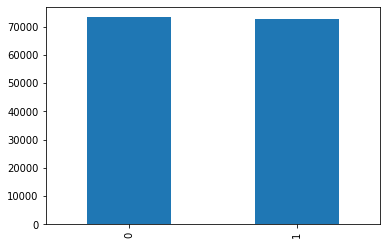

In [40]:
# 학습 데이터의 레이블 구성 비율 확인
print(train_data['label'].value_counts())
train_data['label'].value_counts().plot(kind='bar')

In [41]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  73342
1      1  72841


In [42]:
# 결측지 존재 여부 확인
train_data.isnull().values.any()

True

In [43]:
# 필드별 결측지 갯수 확인
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [44]:
# nan 데이터 확인
train_data.loc[train_data.document.isna()]

,id,document,label
25857,2172111,NaN,1


In [45]:
# NaN 값 제거
train_data=train_data.dropna(how="any")  # 결측지가 존재하는 행 삭제
train_data.isnull().values.any()

False

In [46]:
print(f'훈련용 리뷰 데이터:{train_data.shape}')

훈련용 리뷰 데이터:(146182, 3)


In [47]:
train_data['document']

0                                       아 더빙.. 진짜 짜증나네요 목소리
1                         흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                             교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
149995                                  인간이 문제지.. 소는 뭔죄인가..
149996                                        평점이 너무 낮아서...
149997                      이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?
149998                          청춘 영화의 최고봉.방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 146182, dtype: object

In [48]:
train_data['document']=train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]',"")
train_data['document']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


0                                         아 더빙 진짜 짜증나네요 목소리
1                                흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                                 교도소 이야기구먼 솔직히 재미는 없다평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
                                ...                        
149995                                      인간이 문제지 소는 뭔죄인가
149996                                           평점이 너무 낮아서
149997                        이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다
149998                           청춘 영화의 최고봉방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 146182, dtype: object

In [50]:
train_data=train_data[train_data['document']!=""]
train_data.shape

(145791, 3)

In [51]:
stopwords = ['의','가','이','은','들','는','좀',
             '잘','걍','과','도','를','으로','자',
             '에','와','한','하다']

In [52]:
okt = Okt()
X_train = []
for doct in train_data["document"]:
    tmp_x = []
    tmp_x = okt.morphs(doct, stem=True)
    tmp_x = [word for word in tmp_x if not word in stopwords]
    X_train.append(tmp_x)

In [55]:
# 테스트 데이터 전처리
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data['document']=test_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]',"")
test_data['document'].replace("", np.nan, inplace=True)
test_data = test_data.dropna(how='any')
test_data.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


(48417, 3)

In [56]:
# 테스트 데이터 토큰화
X_test = []
for doct in test_data['document']:
    tmp_x =[]
    tmp_x =okt.morphs(doct, stem=True)  # 토큰화
    tmp_x = [word for word in tmp_x if not word in stopwords]
    X_test.append(tmp_x)

In [ ]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
tokenizer.word_index 

In [58]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [59]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거
vocab_size = total_cnt - rare_cnt + 2
print("단어 집합의 크기:",vocab_size)

단어 집합의 크기: 19417


In [60]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [61]:
print(X_train[:3])

[[51, 455, 17, 261, 660], [934, 458, 42, 603, 2, 215, 1450, 25, 962, 676, 20], [387, 2445, 1, 2316, 5672, 3, 223, 10]]


In [62]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [63]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_train[:3]

[404, 412, 470]

In [64]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145380
145380


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 11.002187371027652


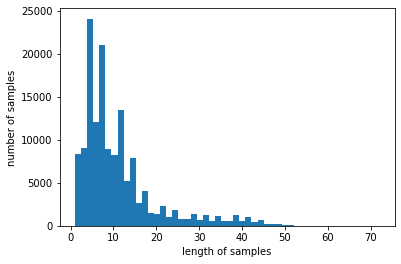

In [65]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [66]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [67]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.0830925849498


In [68]:
print('시퀀스 패딩(sample * time)')
X_train=sequence.pad_sequences(X_train,maxlen=max_len)
X_test=sequence.pad_sequences(X_test,maxlen=max_len)
print('X_train 크기 :',X_train.shape)
print('X_test 크기 : ', X_test.shape)

시퀀스 패딩(sample * time)
X_train 크기 : (145380, 30)
X_test 크기 :  (48417, 30)


In [69]:
# LSTM 
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [70]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [71]:
# 검증 데이터 손실(val_loss)이 증가하면, 
# 과적합 징후므로 검증 데이터 손실이 4회 증가하면 
# 학습을 조기 종료(Early Stopping)합니다. 
es = EarlyStopping(monitor='val_loss', 
                   mode='min', verbose=1, patience=4)
# ModelCheckpoint를 사용하여 검증 데이터의 
# 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다.
mc = ModelCheckpoint('best_model.h5', 
                     monitor='val_acc', mode='max', 
                     verbose=2, save_best_only=True)

In [72]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    callbacks=[es, mc], 
                    batch_size=60, 
                    validation_split=0.2)

Epoch 1/10
1938/1939 [============================>.] - ETA: 0s - loss: 0.3901 - acc: 0.8210
Epoch 1: val_acc improved from -inf to 0.84362, saving model to best_model.h5
1939/1939 [==============================] - 188s 94ms/step - loss: 0.3901 - acc: 0.8210 - val_loss: 0.3535 - val_acc: 0.8436
Epoch 2/10
1938/1939 [============================>.] - ETA: 0s - loss: 0.3286 - acc: 0.8576
Epoch 2: val_acc improved from 0.84362 to 0.85356, saving model to best_model.h5
1939/1939 [==============================] - 177s 91ms/step - loss: 0.3285 - acc: 0.8576 - val_loss: 0.3359 - val_acc: 0.8536
Epoch 3/10
1938/1939 [============================>.] - ETA: 0s - loss: 0.3026 - acc: 0.8714
Epoch 3: val_acc improved from 0.85356 to 0.85713, saving model to best_model.h5
1939/1939 [==============================] - 162s 84ms/step - loss: 0.3026 - acc: 0.8714 - val_loss: 0.3369 - val_acc: 0.8571
Epoch 4/10
1938/1939 [============================>.] - ETA: 0s - loss: 0.2843 - acc: 0.8811
Epoch 4: v

In [73]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1514/1514 [==============================] - 25s 16ms/step - loss: 0.3358 - acc: 0.8558

 테스트 정확도: 0.8558


In [74]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = sequence.pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [75]:
sentiment_predict("이 영화 개꿀잼 ㅋㅋㅋ")

96.62% 확률로 긍정 리뷰입니다.



In [76]:
sentiment_predict("이게 영화냐?ㅠㅠ")

85.56% 확률로 부정 리뷰입니다.



In [78]:
sentiment_predict("이 영화 개재미 없음")

97.77% 확률로 부정 리뷰입니다.

